In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import copy

import torch
import torch.nn.functional as F

import sys
 
# sys.path.append('/content/drive/MyDrive/neuro_research/stp_networks/')
sys.path.append('./paper/')
import networks as nets
import net_utils as net_utils
import int_data as syn
import analysis as analysis
import context_data as context
from data import generate_recog_data, generate_recog_data_batch
from plotting import plot_generalization, get_recog_positive_rates

c_vals = ['firebrick', 'darkgreen', 'blue', 'darkorange', 'm', 'deeppink', 'r', 'gray', 'g', 'navy', 
                'y', 'purple', 'cyan', 'olive', 'skyblue', 'pink', 'tan']
c_vals_l = ['salmon', 'limegreen', 'cornflowerblue', 'bisque', 'plum', 'pink', 'tomato', 'lightgray', 'g', 'b', 
                      'y', 'purple', 'cyan', 'olive', 'skyblue', 'pink', 'tan']

def participation_ratio_vector(C):
    """Computes the participation ratio of a vector of variances."""
    return np.sum(C) ** 2 / np.sum(C*C)

In [3]:
# # Reload modules if changes have been made to them
# from importlib import reload

# reload(net_utils)
# reload(nets)
# reload(syn)
# reload(analysis)
# reload(context)

Define some helpful functions for training that will be used below.

In [4]:
from net_utils import xe_classifier_accuracy

def init_net(net_params, verbose=True):
    
    # initialize net with default values
    input_dims = [net_params['n_inputs'], net_params['n_hidden'], net_params['n_outputs']]

    if net_params['netType'] in ('MPN',):
        # netClass = nets.HebbNet
        netClass = MultiPlasticNet
    elif net_params['netType'] in ('MPN2',):
        netClass = MultiPlasticNetTwo        
        input_dims.insert(1, net_params['n_hidden'])
    elif net_params['netType'] in ('MPN_rec',):
        netClass = MultiPlasticNetRec   
    else:
        raise ValueError('netType not recognized.')

    net = netClass(input_dims, verbose=verbose, MAct=net_params['MAct'])

    return net

def train_network(net_params, toy_params, current_net=None, save=False, save_root='', 
                  set_seed=True, verbose=True):
    """ 
    Code to train a single network. 
    
    OUTPUTS:
    net: the trained network
    toy_params: these are updated when data is generated

    """

    # Sets the random seed for reproducibility (this affects both data generation and network)
    if 'seed' in net_params and set_seed:
        if net_params['seed'] is not None: 
            np.random.seed(seed=net_params['seed'])
            torch.manual_seed(net_params['seed'])
    
    # Intitializes network and puts it on device
    if net_params['cuda']:
        if verbose: print('Using CUDA...')
        device = torch.device('cuda')
    else:
        if verbose: print('Using CPU...')
        device = torch.device('cpu')

    net = init_net(net_params, verbose=verbose)
    net.to(device)

    # Continually generates new data to train on
    # This will iterate in loop so that it only sees each type of data a set amount of times
    net_params['epochs'] = 0 if current_net is None else net.hist['epoch']
    validData, validOutputMask, _ = syn.generate_data(
        net_params['valid_set_size'], toy_params, net_params['n_outputs'], 
        verbose=False, auto_balance=False, device=device)
    early_stop = False
    new_thresh = True # Triggers threshold setting for first call of .fit, but turns off after first call

    while not early_stop:
        net_params['epochs'] += 10 # Number of times each example is passed to the network
        trainData, trainOutputMask, toy_params = syn.generate_data(
            net_params['train_set_size'], toy_params, net_params['n_outputs'], 
            verbose=False, auto_balance=False, device=device)
        
        early_stop = net.fit('sequence', epochs=net_params['epochs'], 
                             trainData=trainData, batchSize=net_params['batch_size'],
                             validBatch=validData[:,:,:], learningRate=net_params['learning_rate'],
                             newThresh=new_thresh, monitorFreq=50, 
                             trainOutputMask=trainOutputMask, validOutputMask=validOutputMask,
                             validStopThres=net_params['accEarlyStop'], weightReg=net_params['weight_reg'], 
                             regLambda=net_params['reg_lambda'], gradientClip=net_params['gradient_clip'],
                             earlyStopValid=net_params['validEarlyStop'], minMaxIter=net_params['minMaxIter']) 
        new_thresh = False   

    return net, toy_params, net_params

### Two-layer MPN

This is a stripped-down version of the two-layer MPN network used in the paper, where the first weight layer has two types of plasticity and the readout layer is only trained with backprop. See `networks` for full version.

In [24]:
from torch import nn
import torch.nn.functional as F
from networks import MultiPlasticLayer
from net_utils import StatefulBase, random_weight_init, xe_classifier_accuracy


class MultiPlasticNet(StatefulBase):
    """
    Two-layer feedforward setup, with single multi-plastic layer followed by a readout layer.

    Same architecture used in "Neural Population Dynamics of Computing with Synaptic Modulations"
    """

    def __init__(self, init, verbose=True, **mpnArgs):
        super(MultiPlasticNet, self).__init__()

        Nx, Nh, Ny = init
        # For readouts
        W, b = random_weight_init([Nh, Ny], bias=True)

        self.n_inputs = Nx
        self.n_hidden = Nh
        self.n_outputs = Ny

        self.loss_fn = F.cross_entropy  # Reductions is mean by default
        self.acc_fn = xe_classifier_accuracy

        # Creates the input MP layer
        self.mp_layer = MultiPlasticLayer(
            (self.n_inputs, self.n_hidden), verbose=verbose, **mpnArgs
        )

        # Input layer activation
        self.f = torch.tanh
        # Readout layer
        self.w2 = nn.Parameter(torch.tensor(W[0], dtype=torch.float))
        # Readout bias is not used (easier interpretting readouts in the latter)'
        self.register_buffer("b2", torch.zeros_like(torch.tensor(b[0])))

    def reset_state(self, batchSize=1):
        """
        Resets states of all internal layer SM matrices
        """
        self.mp_layer.reset_state(batchSize=batchSize)

    def forward(self, x, debug=False):
        """
        This modifies the internal state of the model (self.M).
        Don't call twice in a row unless you want to update self.M twice!

        x.shape: [B, Nx]
        b1.shape: [Nh]
        w1.shape=[Nx,Nh],
        M.shape=[B,Nh,Nx],

        """
        # Apply input multi-plastic layer, returns pre-activation
        h_tilde = self.mp_layer(x, debug=debug)
        h = self.f(h_tilde)

        # M updated internally when this is called
        self.mp_layer.update_sm_matrix(x, h)

        # (1, Ny) + [(B, Nh,) x (Nh, Ny) = (B, Ny)] = (B, Ny)
        y_tilde = self.b2.unsqueeze(0) + torch.mm(h.squeeze(dim=2), torch.transpose(self.w2, 0, 1))
        y = y_tilde

        if debug:
            return h_tilde, h, y_tilde, y, self.mp_layer.M
        else:
            return y

    def evaluate(self, batch):
        """
        Runs a full sequence of the given back size through the network.
        """
        # Begin by resetting the state
        self.reset_state(batchSize=batch[0].shape[0])

        out_size = torch.Size(
            [batch[1].shape[0], batch[1].shape[1], self.n_outputs]
        )  # [B, T, Ny]
        out = torch.empty(
            out_size, dtype=torch.float, layout=batch[1].layout, device=batch[1].device
        )

        for time_idx in range(batch[0].shape[1]):
            x = batch[0][:, time_idx, :]  # [B, Nx]
            out[:, time_idx] = self(x)

        return out

    @torch.no_grad()
    def evaluate_debug(self, batch, batchMask=None, acc=True, reset=True):
        """
        Runs a full sequence of the given back size through the network, but now keeps track of all sorts of parameters
        """
        B = batch[0].shape[0]

        if reset:
            self.reset_state(batchSize=B)

        Nx = self.n_inputs
        Nh = self.n_hidden
        Ny = self.n_outputs
        T = batch[1].shape[1]
        db = {
            "x": torch.empty(B, T, Nx),
            "h_tilde": torch.empty(B, T, Nh),
            "h": torch.empty(B, T, Nh),
            "Wxb": torch.empty(B, T, Nh),
            "M": torch.empty(B, T, Nh, Nx),
            "Mx": torch.empty(B, T, Nh),
            "y_tilde": torch.empty(B, T, Ny),
            "out": torch.empty(B, T, Ny),
        }
        for time_idx in range(batch[0].shape[1]):
            x = batch[0][:, time_idx, :]  # [B, Nx]
            db["x"][:, time_idx, :] = x

            (
                db["h_tilde"][:, time_idx],
                db["h"][:, time_idx, :],
                db["y_tilde"][:, time_idx, :],
                db["out"][:, time_idx, :],
                db["M"][:, time_idx, :],
            ) = self(x, debug=True)
            db["Mx"][:, time_idx, :] = torch.bmm(
                self.mp_layer.M, x.unsqueeze(2)
            ).squeeze(2)

            db["Wxb"][:, time_idx] = self.mp_layer.b1.unsqueeze(0) + torch.mm(
                x, torch.transpose(self.mp_layer.w1, 0, 1)
            )

        if acc:
            db["acc"] = self.accuracy(
                batch, out=db["out"].to(self.w2.device), outputMask=batchMask
            ).item()

        return db

#### Train

In [26]:
########## Toy data parameters ##########
toy_params = {
    'data_type': 'int', 
    
    'phrase_length': 20,
    'n_classes': 3,
    'input_type': 'binary',    # one_hot, binary, binary1-1
    'input_size': 50,          # defaults to length of words
    'include_eos': True,

    'n_delay': 0, # Inserts delay words (>0: at end, <0: at beginning)

    'uniform_score': True, # Uniform distribution over scores=
}

net_params = {
    'netType': 'MPN', # MPN, MPN2, MPN_rec
    'n_inputs': toy_params['input_size'],           # input dim
    'n_hidden': 100,                                # hidden dim
    'n_outputs': toy_params['n_classes'],           # output dim

    'MAct': None, # Activation function of M updates

    # Train parameters
    'learning_rate': 1e-3,
    'weight_reg': 'L1',
    'reg_lambda': 1e-4,
    'gradient_clip': 10,
    
    'validEarlyStop': False,      # Early stop when average validation loss saturates
    'accEarlyStop': 0.98,         # Accuracy to stop early at (None to ignore)
    'minMaxIter': (50, 100),  # Bounds on training time
    'seed': 2001,                 # This seed is used to generate training/valid data too

    'train_set_size': 3200,
    'valid_set_size': 500,
    'batch_size': 64,
    'epochs': 40,
    # 'cuda': True,
    'cuda': False,
}

net_params['train_mode'] = 'seq_inf'

net, toy_params, net_params = train_network(net_params, toy_params)

Using CPU...
MP Layer parameters:
  MP Type: Additive // Activation: sigmoid // (Nx, Ny) = (50, 100)
  Layer bias: trainable // Sparsification: 0.00 // Layer Noise: None
  SM matrix parameters:
    M update: Hebbian // M Act: linear // M0: zeros
    Eta: scalar // Lam: scalar // Lambda_max: 1.00
Train parameters:
  Loss: XE // LR: 1.00e-03 // Weight reg: L1, coef: 1.0e-04 // Gradient clip: 1.0e+01
Iter:0 lr:1.000e-03 grad:8.695 train_loss:1.2636 train_acc:0.250 valid_loss:1.1917 valid_acc:0.358
Iter:50 lr:1.000e-03 grad:6.018 train_loss:1.1525 train_acc:0.219 valid_loss:1.1317 valid_acc:0.334
Iter:100 lr:1.000e-03 grad:3.974 train_loss:1.1200 train_acc:0.297 valid_loss:1.1213 valid_acc:0.308
  Early Stop: maximum iterations reached, acc: 0.33


See training history

(0.8960387229919434, 1.5163503170013428)

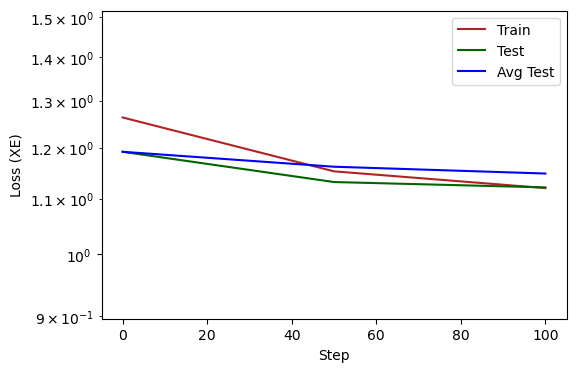

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,4))

ax1.plot(net.hist['iters_monitor'], net.hist['train_loss'], color=c_vals[0], label='Train')
ax1.plot(net.hist['iters_monitor'], net.hist['valid_loss'], color=c_vals[1], label='Test')
ax1.plot(net.hist['iters_monitor'], net.hist['avg_valid_loss'], color=c_vals[2], label='Avg Test')

ax1.set_xlabel('Step')
ax1.set_ylabel('Loss (XE)')
ax1.legend()

ax1.axhline(0.0, color='k', linestyle='dashed')

ax1.set_yscale('log')

ax1.set_ylim((0.8*np.min(net.hist['train_loss']),
              1.2*np.max(net.hist['train_loss'])))

#### Visualize dynamics

In [28]:
from torch.utils.data import TensorDataset

test_set_size = 1000
device = net.w2.device

testData, testOutputMask, testRaw, _ = syn.generate_data(
    test_set_size, toy_params, net_params['n_outputs'], auto_balance=False, 
    raw_data=True, device=device)
db = net.evaluate_debug(testData[:,:,:], batchMask=testOutputMask)

print('Accuracy: {:.3f}'.format(db['acc']))

labels = np.array(testData[:,:,:][1][:, -1, 0].cpu())
hs = db['h'].cpu().numpy()
print('Hidden size:', hs.shape)

ro_matrix = np.array(net.w2.detach().cpu())
print('RO shape', ro_matrix.shape)

Synthentic data generated in: 0.17 sec. Autobalanced: False. Uniform score: True. Eliminate ties: True


TypeError: tanh(): argument 'input' (position 1) must be Tensor, not tuple

In [ ]:
n_components = 100
hidden_PCA = PCA(n_components=n_components)

hidden_PCA.fit(hs.reshape((-1, hs.shape[-1])))

hs_pca = np.zeros((hs.shape[0], hs.shape[1], n_components,))

for batch_idx in range(hs.shape[0]):
    hs_pca[batch_idx] = hidden_PCA.transform(hs[batch_idx])

zero_matrix_pca = hidden_PCA.transform(np.zeros_like(ro_matrix))
ro_matrix_pca = hidden_PCA.transform(ro_matrix)

print('PCA shape:', hs_pca.shape)
print('Variances:', ['{:.2f}'.format(var) for var in hidden_PCA.explained_variance_[:10]])
print('PR: {:.2f}'.format(participation_ratio_vector(hidden_PCA.explained_variance_)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

pcxs = (0, 0, 1)
pcys = (1, 2, 2)

phrase_len = hs.shape[1]

n_rand_examples = 2
rand_example_idxs = np.random.randint(hs.shape[0], size=(n_rand_examples,))

for ax, pcx, pcy in zip((ax1, ax2, ax3), pcxs, pcys):
    for example_idx in range(hs.shape[0]): # Hidden activity
        ax.scatter(hs_pca[example_idx, :, pcx], hs_pca[example_idx, :, pcy], linewidth=0.0,
                   marker='.', color=c_vals_l[labels[example_idx]], zorder=0, alpha=0.5)
        ax.scatter(hs_pca[example_idx, -1, pcx], hs_pca[example_idx, -1, pcy], marker='o',
                   color=c_vals[labels[example_idx]], zorder=5, alpha=0.5)

    for ro_idx in range(net_params['n_outputs']): # Readouts
        ax.plot([zero_matrix_pca[ro_idx, pcx], ro_matrix_pca[ro_idx, pcx]], 
                [zero_matrix_pca[ro_idx, pcy], ro_matrix_pca[ro_idx, pcy]],
                 color=c_vals[ro_idx], linewidth=3.0, zorder=10)

    for rand_example_idx in rand_example_idxs: # Example trajectories
        ax.plot(hs_pca[rand_example_idx, :, pcx], hs_pca[rand_example_idx, :, pcy],
                color=c_vals[labels[rand_example_idx]], zorder=1)

    ax.set_xlabel('PC{}'.format(pcx))
    ax.set_ylabel('PC{}'.format(pcy))
    
ax2.set_title('Hidden state PC plots (color by phrase label)')

### Three-layer MPN

Same as the two-layer MPN, but now has an additional feedforward layer that also has multi-plasticity (so the first two weight layers have multi-plasticity, but the readout layer is still only trained with backprop). Stripped down version, see `networks` for full version.

In [29]:
from torch import nn
import torch.nn.functional as F
from networks import MultiPlasticLayer
from net_utils import StatefulBase, random_weight_init, xe_classifier_accuracy

class MultiPlasticNetTwo(StatefulBase):
    """
    Same as above but has two multi-plastic layers followed by a readout layer.
    """     
    def __init__(self, init, verbose=True, **mpnArgs):        
        super(MultiPlasticNetTwo, self).__init__()        
        
        Nx,Nh1,Nh2,Ny = init
        # For readouts
        W,b = random_weight_init([Nh2,Ny], bias=True)
        
        self.n_inputs = Nx
        self.n_hidden1 = Nh1
        self.n_hidden2 = Nh2
        self.n_outputs = Ny 
        
        self.loss_fn = F.cross_entropy # Reductions is mean by default
        self.acc_fn = xe_classifier_accuracy 

        # Creates the MP layers
        self.mp_layer1 = MultiPlasticLayer((self.n_inputs, self.n_hidden1), verbose=verbose, **mpnArgs)
        self.mp_layer2 = MultiPlasticLayer((self.n_hidden1, self.n_hidden2), verbose=verbose, **mpnArgs)

        # Hidden layer activations
        self.f1 = torch.tanh
        self.f2 = torch.tanh

        # Readout layer
        self.w2 = nn.Parameter(torch.tensor(W[0], dtype=torch.float))
        # Readout bias is not used (easier interpretting readouts in the latter)
        self.register_buffer('b2', torch.zeros_like(torch.tensor(b[0])))
    
    def reset_state(self, batchSize=1):
        """
        Resets states of all internal layer SM matrices
        """
        self.mp_layer1.reset_state(batchSize=batchSize)
        self.mp_layer2.reset_state(batchSize=batchSize)    

    def forward(self, x, debug=False):
        """
        This modifies the internal state of the model (self.M). 
        Don't call twice in a row unless you want to update self.M twice!

        x.shape: [B, Nx]
        b1.shape: [Nh]
        w1.shape=[Nx,Nh], 
        A.shape=[B,Nh,Nx], 

        """

        # Apply input multi-plastic layer, returns pre-activation
        h_tilde1 = self.mp_layer1(x, debug=debug)
        h1 = self.f1(h_tilde1)

        # M updated internally 
        self.mp_layer1.update_sm_matrix(x, h1)        
        
        h_tilde2 = self.mp_layer2(h1, debug=debug)
        h2 = self.f2(h_tilde2) 

        self.mp_layer2.update_sm_matrix(h1, h2)  

        # (1, Ny) + [(B, Nh,) x (Nh, Ny) = (B, Ny)] = (B, Ny)
        y_tilde = self.b2.unsqueeze(0) + torch.mm(h2, torch.transpose(self.w2, 0, 1)) #output layer activation
        y = y_tilde  
                           
        if debug:
            return (h_tilde1, h1, h_tilde2, h2, y_tilde, y, self.mp_layer1.M, self.mp_layer2.M)
        else:
            return y   
     
    def evaluate(self, batch):
        """
        Runs a full sequence of the given back size through the network.
        """
        self.reset_state(batchSize=batch[0].shape[0])

        out_size = torch.Size([batch[1].shape[0], batch[1].shape[1], self.n_outputs]) # [B, T, Ny]
        out = torch.empty(out_size, dtype=torch.float, layout=batch[1].layout, device=batch[1].device)

        for time_idx in range(batch[0].shape[1]):

            x = batch[0][:, time_idx, :] # [B, Nx]
            out[:, time_idx] = self(x)

        return out
        
    @torch.no_grad()    
    def evaluate_debug(self, batch, batchMask=None, acc=True, reset=True):
        """ 
        Runs a full sequence of the given back size through the network, but now keeps track of all sorts of parameters
        """
        B = batch[0].shape[0]

        if reset:
            self.reset_state(batchSize=B)

        Nx = self.n_inputs
        Nh1 = self.n_hidden1
        Nh2 = self.n_hidden2
        Ny = self.n_outputs
        T = batch[1].shape[1]
        db = {'x' : torch.empty(B,T,Nx),
              'h_tilde1' : torch.empty(B,T,Nh1),
              'h1' : torch.empty(B,T,Nh1),
              'M1': torch.empty(B,T,Nh1,Nx),
              'h_tilde2' : torch.empty(B,T,Nh2),
              'h2' : torch.empty(B,T,Nh2),
              'M2': torch.empty(B,T,Nh2,Nh1),
              'y_tilde' : torch.empty(B,T,Ny),
              'out' : torch.empty(B,T,Ny),
              }
        for time_idx in range(batch[0].shape[1]):
            x = batch[0][:, time_idx, :] # [B, Nx]
            db['x'][:,time_idx,:] = x

            (db['h_tilde1'][:,time_idx], db['h1'][:,time_idx,:], 
                db['h_tilde2'][:,time_idx], db['h2'][:,time_idx,:],
                db['y_tilde'][:,time_idx,:], db['out'][:,time_idx,:], 
                db['M1'][:,time_idx,:], db['M2'][:,time_idx,:]) = self(x, debug=True)      
            
        
        if acc:
            db['acc'] = self.accuracy(batch, out=db['out'].to(self.w2.device), outputMask=batchMask).item()  
                             
        return db

#### Train

In [30]:
########## Toy data parameters ##########
toy_params = {
    'data_type': 'int', 
    
    'phrase_length': 20,
    'n_classes': 3,
    'input_type': 'binary',    # one_hot, binary, binary1-1
    'input_size': 50,          # defaults to length of words
    'include_eos': True,

    'n_delay': 0, # Inserts delay words (>0: at end, <0: at beginning)

    'uniform_score': True, # Uniform distribution over scores=
}

net_params = {
    'netType': 'MPN2', # MPN, MPN2, MPN_rec
    'n_inputs': toy_params['input_size'],           # input dim
    'n_hidden': 100,                                # hidden dim
    'n_outputs': toy_params['n_classes'],         # output dim

    'MAct': None, # Activation function of M updates

    # Train parameters
    'learning_rate': 1e-3,
    'weight_reg': 'L1',
    'reg_lambda': 1e-4,
    'gradient_clip': 10,
    
    'validEarlyStop': False,     # Early stop when average validation loss saturates
    'accEarlyStop': 0.98,       # Accuracy to stop early at (None to ignore)
    'minMaxIter': (1000, 10000),  # Bounds on training time
    'seed': 2001,               # This seed is used to generate training/valid data too

    'train_set_size': 3200,
    'valid_set_size': 500,
    'batch_size': 64,
    'epochs': 40,
    'cuda': True,
}

net_params['train_mode'] = 'seq_inf'

net, toy_params, net_params = train_network(net_params, toy_params)

Using CUDA...
MP Layer parameters:
  MP Type: Additive // Activation: sigmoid // (Nx, Ny) = (50, 100)
  Layer bias: trainable // Sparsification: 0.00 // Layer Noise: None
  SM matrix parameters:
    M update: Hebbian // M Act: linear // M0: zeros
    Eta: scalar // Lam: scalar // Lambda_max: 1.00
MP Layer parameters:
  MP Type: Additive // Activation: sigmoid // (Nx, Ny) = (100, 100)
  Layer bias: trainable // Sparsification: 0.00 // Layer Noise: None
  SM matrix parameters:
    M update: Hebbian // M Act: linear // M0: zeros
    Eta: scalar // Lam: scalar // Lambda_max: 1.00


AssertionError: Torch not compiled with CUDA enabled

See training history

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,4))

ax1.plot(net.hist['iters_monitor'], net.hist['train_loss'], color=c_vals[0], label='Train')
ax1.plot(net.hist['iters_monitor'], net.hist['valid_loss'], color=c_vals[1], label='Test')
ax1.plot(net.hist['iters_monitor'], net.hist['avg_valid_loss'], color=c_vals[2], label='Avg Test')

ax1.set_xlabel('Step')
ax1.set_ylabel('Loss (XE)')
ax1.legend()

ax1.axhline(0.0, color='k', linestyle='dashed')

ax1.set_yscale('log')

ax1.set_ylim((0.8*np.min(net.hist['train_loss']),
              1.2*np.max(net.hist['train_loss'])))

#### Visualize dynamics

In [ ]:
from torch.utils.data import TensorDataset

test_set_size = 1000
device = net.w2.device

testData, testOutputMask, testRaw, _ = syn.generate_data(
    test_set_size, toy_params, net_params['n_outputs'], auto_balance=False, 
    raw_data=True, device=device)
db = net.evaluate_debug(testData[:,:,:], batchMask=testOutputMask)

print('Accuracy: {:.3f}'.format(db['acc']))

labels = np.array(testData[:,:,:][1][:, -1, 0].cpu())
h1s = db['h1'].cpu().numpy()
h2s = db['h2'].cpu().numpy()
print('Hidden1 size:', h1s.shape)
print('Hidden2 size:', h2s.shape)

ro_matrix = np.array(net.w2.detach().cpu())
print('RO shape', ro_matrix.shape)

In [ ]:
n_components = 100

n_rand_examples = 2
rand_example_idxs = np.random.randint(hs.shape[0], size=(n_rand_examples,))

for hs_idx, hs in enumerate((h1s, h2s)):

    hidden_PCA = PCA(n_components=n_components)

    hidden_PCA.fit(hs.reshape((-1, hs.shape[-1])))

    hs_pca = np.zeros((hs.shape[0], hs.shape[1], n_components,))

    for batch_idx in range(hs.shape[0]):
        hs_pca[batch_idx] = hidden_PCA.transform(hs[batch_idx])

    zero_matrix_pca = hidden_PCA.transform(np.zeros_like(ro_matrix))
    ro_matrix_pca = hidden_PCA.transform(ro_matrix)

    print('PCA shape:', hs_pca.shape)
    print('Variances:', ['{:.2f}'.format(var) for var in hidden_PCA.explained_variance_[:10]])
    print('PR: {:.2f}'.format(participation_ratio_vector(hidden_PCA.explained_variance_)))

    if hs_idx == 0:
        fig1, axs = plt.subplots(1, 3, figsize=(16,4))
    else:
        fig2, axs = plt.subplots(1, 3, figsize=(16,4))

    pcxs = (0, 0, 1)
    pcys = (1, 2, 2)

    phrase_len = hs.shape[1]

    for ax, pcx, pcy in zip(axs, pcxs, pcys):
        for batch_idx in range(hs.shape[0]): # Hidden activity
            ax.scatter(hs_pca[batch_idx, :, pcx], hs_pca[batch_idx, :, pcy], linewidth=0.0,
                    marker='.', color=c_vals_l[labels[batch_idx]], zorder=0, alpha=0.5)
            ax.scatter(hs_pca[batch_idx, -1, pcx], hs_pca[batch_idx, -1, pcy], marker='o',
                    color=c_vals[labels[batch_idx]], zorder=5, alpha=0.5)

        if hs_idx == 1:
            for ro_idx in range(net_params['n_outputs']): # Readouts
                ax.plot([zero_matrix_pca[ro_idx, pcx], ro_matrix_pca[ro_idx, pcx]], 
                        [zero_matrix_pca[ro_idx, pcy], ro_matrix_pca[ro_idx, pcy]],
                        color=c_vals[ro_idx], linewidth=3.0, zorder=10)
            
        for rand_example_idx in rand_example_idxs: # Example trajectories
            ax.plot(hs_pca[rand_example_idx, :, pcx], hs_pca[rand_example_idx, :, pcy],
                    color=c_vals[labels[rand_example_idx]], zorder=1)

        ax.set_xlabel('PC{}'.format(pcx))
        ax.set_ylabel('PC{}'.format(pcy))
        
    ax2.set_title('Hidden {} state PC plots (color by phrase label)'.format(hs_idx+1))

### Recurrent MPN

Same as the two-layer MPN, but now has a recurrent layer (in the same way a Vanilla RNN has one) that also has multi-plasticity. Note that in order for this to train well, the SM matrix must be bounded, so here we have added a tanh activation function around the M updates. Stripped down version, see `networks` for full version.

In [42]:
from torch import nn
import torch.nn.functional as F
from networks import MultiPlasticLayer
from net_utils import StatefulBase, random_weight_init, xe_classifier_accuracy

class MultiPlasticNetRec(StatefulBase):
    """
    Recurrent neural network with multi-plastic layers on W_inp and W_rec
    """     
    def __init__(self, init, verbose=True, **mpnArgs):        
        super(MultiPlasticNetRec, self).__init__()        

        Nx,Nh,Ny = init
        # For readouts
        W,b = random_weight_init([Nh,Ny], bias=True)
        
        self.n_inputs = Nx
        self.n_hidden = Nh
        self.n_outputs = Ny 

        self.loss_fn = F.cross_entropy # Reductions is mean by default
        self.acc_fn = xe_classifier_accuracy 

        # Creates the input MP layer
        self.mp_layer_inp = MultiPlasticLayer((self.n_inputs, self.n_hidden), verbose=verbose, **mpnArgs)
        self.mp_layer_rec = MultiPlasticLayer((self.n_hidden, self.n_hidden), verbose=verbose, **mpnArgs)

        self.f = torch.tanh
        
        # Readout layer (always trainable)
        self.w2 = nn.Parameter(torch.tensor(W[0], dtype=torch.float))
        # Readout bias is not used (easier interpretting readouts in the latter)
        self.register_buffer('b2', torch.zeros_like(torch.tensor(b[0])))

        # Fixed initial hidden activity
        _, b_hidden = random_weight_init([1,Nh], bias=True) 
        self.register_buffer('h0', torch.zeros_like(torch.tensor(b_hidden[0], dtype=torch.float)))
    
    def reset_state(self, batchSize=1):
        """
        Resets states of all internal layer SM matrices and hidden layer
        """
        self.mp_layer_inp.reset_state(batchSize=batchSize)
        self.mp_layer_rec.reset_state(batchSize=batchSize)    

        self.h = torch.ones((batchSize, self.n_hidden), 
                            device=self.w2.device) #shape=[B,Nh]  
        self.h = self.h * self.h0.unsqueeze(0)

    def forward(self, x, debug=False, stateOnly=False):
        """
        This modifies the internal state of the model (self.M). 
        Don't call twice in a row unless you want to update self.M twice!

        x.shape: [B, Nx]
        b1.shape: [Nh]
        w1.shape=[Nx,Nh], 
        A.shape=[B,Nh,Nx], 

        """

        # Apply input multi-plastic layer, returns pre-activation
        h_tilde_inp = self.mp_layer_inp(x, debug=debug)
        # Recurrent multi-plastic layer
        h_tilde_rec = self.mp_layer_rec(self.h, debug=debug)

        h_tilde = h_tilde_inp + h_tilde_rec
        h = self.f(h_tilde) 
        
        # Ms updated internally
        self.mp_layer_inp.update_sm_matrix(x, h)  
        self.mp_layer_rec.update_sm_matrix(self.h, h)        

        self.h = h

        # (1, Ny) + [(B, Nh,) x (Nh, Ny) = (B, Ny)] = (B, Ny)
        y_tilde = self.b2.unsqueeze(0) + torch.mm(h, torch.transpose(self.w2, 0, 1)) #output layer activation
        y = y_tilde  
                           
        if debug:
            return (h_tilde_inp, h_tilde_rec, h, y_tilde, y, self.mp_layer_inp.M, self.mp_layer_rec.M)
        else:
            return y   
     
    def evaluate(self, batch):
        """
        Runs a full sequence of the given back size through the network.
        """
        self.reset_state(batchSize=batch[0].shape[0])
        # Output size can differ from batch[1] size because XE loss is now used 
        out_size = torch.Size([batch[1].shape[0], batch[1].shape[1], self.n_outputs]) # [B, T, Ny]

        out = torch.empty(out_size, dtype=torch.float, layout=batch[1].layout, device=batch[1].device)

        for time_idx in range(batch[0].shape[1]):

            x = batch[0][:, time_idx, :] # [B, Nx]
            out[:, time_idx] = self(x)

        return out
        
    @torch.no_grad()    
    def evaluate_debug(self, batch, batchMask=None, acc=True, reset=True):
        """ 
        Runs a full sequence of the given back size through the network, but now keeps track of all sorts of parameters
        """
        B = batch[0].shape[0]

        if reset:
            self.reset_state(batchSize=B)

        Nx = self.n_inputs
        Nh = self.n_hidden
        Ny = self.n_outputs
        T = batch[1].shape[1]
        db = {'x' : torch.empty(B,T,Nx),
              'h_tilde_inp' : torch.empty(B,T,Nh),
              'h_tilde_rec' : torch.empty(B,T,Nh),
              'h' : torch.empty(B,T,Nh),
              'M_inp': torch.empty(B,T,Nh,Nx),
              'M_rec': torch.empty(B,T,Nh,Nh),
              'y_tilde' : torch.empty(B,T,Ny),
              'out' : torch.empty(B,T,Ny),
              }
        for time_idx in range(batch[0].shape[1]):
            x = batch[0][:, time_idx, :] # [B, Nx]
            db['x'][:,time_idx,:] = x

            (db['h_tilde_inp'][:,time_idx], db['h_tilde_rec'][:,time_idx,:], 
                db['h'][:,time_idx],  db['y_tilde'][:,time_idx,:], db['out'][:,time_idx,:], 
                db['M_inp'][:,time_idx,:], db['M_rec'][:,time_idx,:]) = self(x, debug=True)      
        
        if acc:
            db['acc'] = self.accuracy(batch, out=db['out'].to(self.w2.device), outputMask=batchMask).item()  
                             
        return db

#### Train

In [ ]:
########## Toy data parameters ##########
toy_params = {
    'data_type': 'int', 
    
    'phrase_length': 20,
    'n_classes': 3,
    'input_type': 'binary',    # one_hot, binary, binary1-1
    'input_size': 50,          # defaults to length of words
    'include_eos': True,

    'n_delay': 0, # Inserts delay words (>0: at end, <0: at beginning)

    'uniform_score': True, # Uniform distribution over scores=
}

net_params = {
    'netType': 'MPN_rec', # MPN, MPN2, MPN_rec
    'n_inputs': toy_params['input_size'],           # input dim
    'n_hidden': 100,                                # hidden dim
    'n_outputs': toy_params['n_classes'],         # output dim

    # Train parameters
    'learning_rate': 1e-3,
    'weight_reg': 'L1',
    'reg_lambda': 1e-4,
    'gradient_clip': 10,

    'MAct': 'tanh',
    
    'validEarlyStop': False,     # Early stop when average validation loss saturates
    'accEarlyStop': 0.98,       # Accuracy to stop early at (None to ignore)
    'minMaxIter': (1000, 10000),  # Bounds on training time
    'seed': 2001,               # This seed is used to generate training/valid data too

    'train_set_size': 3200,
    'valid_set_size': 500,
    'batch_size': 64,
    'epochs': 40,
    'cuda': True,
}

net_params['train_mode'] = 'seq_inf'

net, toy_params, net_params = train_network(net_params, toy_params)

See training history

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,4))

ax1.plot(net.hist['iters_monitor'], net.hist['train_loss'], color=c_vals[0], label='Train')
ax1.plot(net.hist['iters_monitor'], net.hist['valid_loss'], color=c_vals[1], label='Test')
ax1.plot(net.hist['iters_monitor'], net.hist['avg_valid_loss'], color=c_vals[2], label='Avg Test')

ax1.set_xlabel('Step')
ax1.set_ylabel('Loss (XE)')
ax1.legend()

ax1.axhline(0.0, color='k', linestyle='dashed')

ax1.set_yscale('log')

ax1.set_ylim((0.8*np.min(net.hist['train_loss']),
              1.2*np.max(net.hist['train_loss'])))

#### Visualize dynamics

In [ ]:
from torch.utils.data import TensorDataset

test_set_size = 1000
device = net.w2.device

testData, testOutputMask, testRaw, _ = syn.generate_data(
    test_set_size, toy_params, net_params['n_outputs'], auto_balance=False, 
    raw_data=True, device=device)
db = net.evaluate_debug(testData[:,:,:], batchMask=testOutputMask)

print('Accuracy: {:.3f}'.format(db['acc']))

labels = np.array(testData[:,:,:][1][:, -1, 0].cpu())
hs = db['h'].cpu().numpy()
print('Hidden size:', hs.shape)

ro_matrix = np.array(net.w2.detach().cpu())
print('RO shape', ro_matrix.shape)

In [ ]:
n_components = 100
hidden_PCA = PCA(n_components=n_components)

hidden_PCA.fit(hs.reshape((-1, hs.shape[-1])))

hs_pca = np.zeros((hs.shape[0], hs.shape[1], n_components,))

for batch_idx in range(hs.shape[0]):
    hs_pca[batch_idx] = hidden_PCA.transform(hs[batch_idx])

zero_matrix_pca = hidden_PCA.transform(np.zeros_like(ro_matrix))
ro_matrix_pca = hidden_PCA.transform(ro_matrix)

print('PCA shape:', hs_pca.shape)
print('Variances:', ['{:.2f}'.format(var) for var in hidden_PCA.explained_variance_[:10]])
print('PR: {:.2f}'.format(participation_ratio_vector(hidden_PCA.explained_variance_)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

pcxs = (0, 0, 1)
pcys = (1, 2, 2)

phrase_len = hs.shape[1]

n_rand_examples = 2
rand_example_idxs = np.random.randint(hs.shape[0], size=(n_rand_examples,))

for ax, pcx, pcy in zip((ax1, ax2, ax3), pcxs, pcys):
    for batch_idx in range(hs.shape[0]): # Hidden activity
        ax.scatter(hs_pca[batch_idx, :, pcx], hs_pca[batch_idx, :, pcy], linewidth=0.0,
                   marker='.', color=c_vals_l[labels[batch_idx]], zorder=0, alpha=0.5)
        ax.scatter(hs_pca[batch_idx, -1, pcx], hs_pca[batch_idx, -1, pcy], marker='o',
                   color=c_vals[labels[batch_idx]], zorder=5, alpha=0.5)

    for ro_idx in range(net_params['n_outputs']): # Readouts
        ax.plot([zero_matrix_pca[ro_idx, pcx], ro_matrix_pca[ro_idx, pcx]], 
                [zero_matrix_pca[ro_idx, pcy], ro_matrix_pca[ro_idx, pcy]],
                 color=c_vals[ro_idx], linewidth=3.0, zorder=10)
        
    for rand_example_idx in rand_example_idxs: # Example trajectories
        ax.plot(hs_pca[rand_example_idx, :, pcx], hs_pca[rand_example_idx, :, pcy],
                color=c_vals[labels[rand_example_idx]], zorder=1)

    ax.set_xlabel('PC{}'.format(pcx))
    ax.set_ylabel('PC{}'.format(pcy))
    
ax2.set_title('Hidden state PC plots (color by phrase label)')